In [1]:
!pip install segmentation-models albumentations

  Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)
  Using cached albumentations-1.0.3-py3-none-any.whl (98 kB)
  Using cached opencv_python_headless-4.5.3.56-cp38-cp38-manylinux2014_x86_64.whl (37.1 MB)
  Using cached image_classifiers-1.0.0-py3-none-any.whl (19 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [7]:
%load_ext autoreload
%autoreload 2

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D, concatenate, AveragePooling1D, Reshape, Activation, add, Conv2DTranspose, BatchNormalization, UpSampling2D, SeparableConv2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.losses import CategoricalCrossentropy, Reduction, BinaryCrossentropy
from tensorflow.keras.layers import Lambda
from tensorflow.keras.activations import softmax
from tensorflow import roll, norm, keras
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.applications as A
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import os
import fnmatch
import random
import cv2
import json

import include.supervisely_parser as svp
import include.grid_parser as gp
from include.DataGenerator import DataGenerator

import segmentation_models as sm # for simple segmentation architecture
import albumentations as Alb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
annotation_base_paths = ['./annotation_v2.0/knuff_main1/', './annotation_v2.0/knuff_main2/', './annotation_v2.0/knuff_main3/', './annotation_v2.0/knuff_hill/',]
image_base_paths = ['./data/knuff_main1/', './data/knuff_main2/', './data/knuff_main3/', './data/knuff_hill/']

model_path = './model/ld_autosys.h5'

number_classes = 9 # outer_l, outer_t, outer_r, middle_curb, guide_lane, solid_lane, wait_line, stop_line
output_width = 640 #640#208 # 192 inception 208 vgg16
output_height = 240 #160 #64 # 48 inception 64 vgg16
input_width = 640 #1280 #434
input_height = 240 # 340 #150

val_size = 0.2 # percentage
augmentation = True

batch_size = 32
epochs = 40

transform = Alb.Compose([
    Alb.ShiftScaleRotate(p=1.0),
    Alb.RandomContrast(p=0.9),
    Alb.RandomBrightness(limit=[-0.4,0.2], p=0.8)
])

params = {
    'batch_size': batch_size,
    'input_img_size': (480, 640),
    'target_img_size': (output_height, output_width),
    'shuffle': True,
    'n_channels': number_classes,
    'transform': transform
}

# generate list of all img and ann paths
image_paths = []
ann_paths = []
for index in range(len(image_base_paths)):
    image_base_path = image_base_paths[index]
    annotation_base_path = annotation_base_paths[index]

    file_list = os.listdir(annotation_base_path)
    pattern = '*.json'
    for filename in file_list:
        if fnmatch.fnmatch(filename, pattern):
            ann_paths.append(os.path.join(annotation_base_path, filename))
            image_name = os.path.splitext(filename)[0]
            image_paths.append(os.path.join(image_base_path, image_name))

            if augmentation:
                ann_paths.append(os.path.join(annotation_base_path, filename))
                image_paths.append(os.path.join(image_base_path, f"{image_name}.aug"))


# split into train and val set
size_all = len(image_paths)
val_samples = int(size_all*val_size)
random.Random(size_all).shuffle(image_paths)
random.Random(size_all).shuffle(ann_paths)

train_input_img_paths = image_paths[:-val_samples]
train_target_ann_paths = ann_paths[:-val_samples]
val_input_img_paths = image_paths[-val_samples:]
val_target_ann_paths = ann_paths[-val_samples:]

print(f"Len train img: {len(train_input_img_paths)} len train ann: {len(train_target_ann_paths)}")
print(f"Len val img: {len(val_input_img_paths)} len val ann: {len(val_target_ann_paths)}")

# Generators
train_gen = DataGenerator(train_input_img_paths, train_target_ann_paths, **params)
val_gen = DataGenerator(val_input_img_paths, val_target_ann_paths, **params)

    

Len train img: 436 len train ann: 436
Len val img: 108 len val ann: 108


/opt/conda/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


32


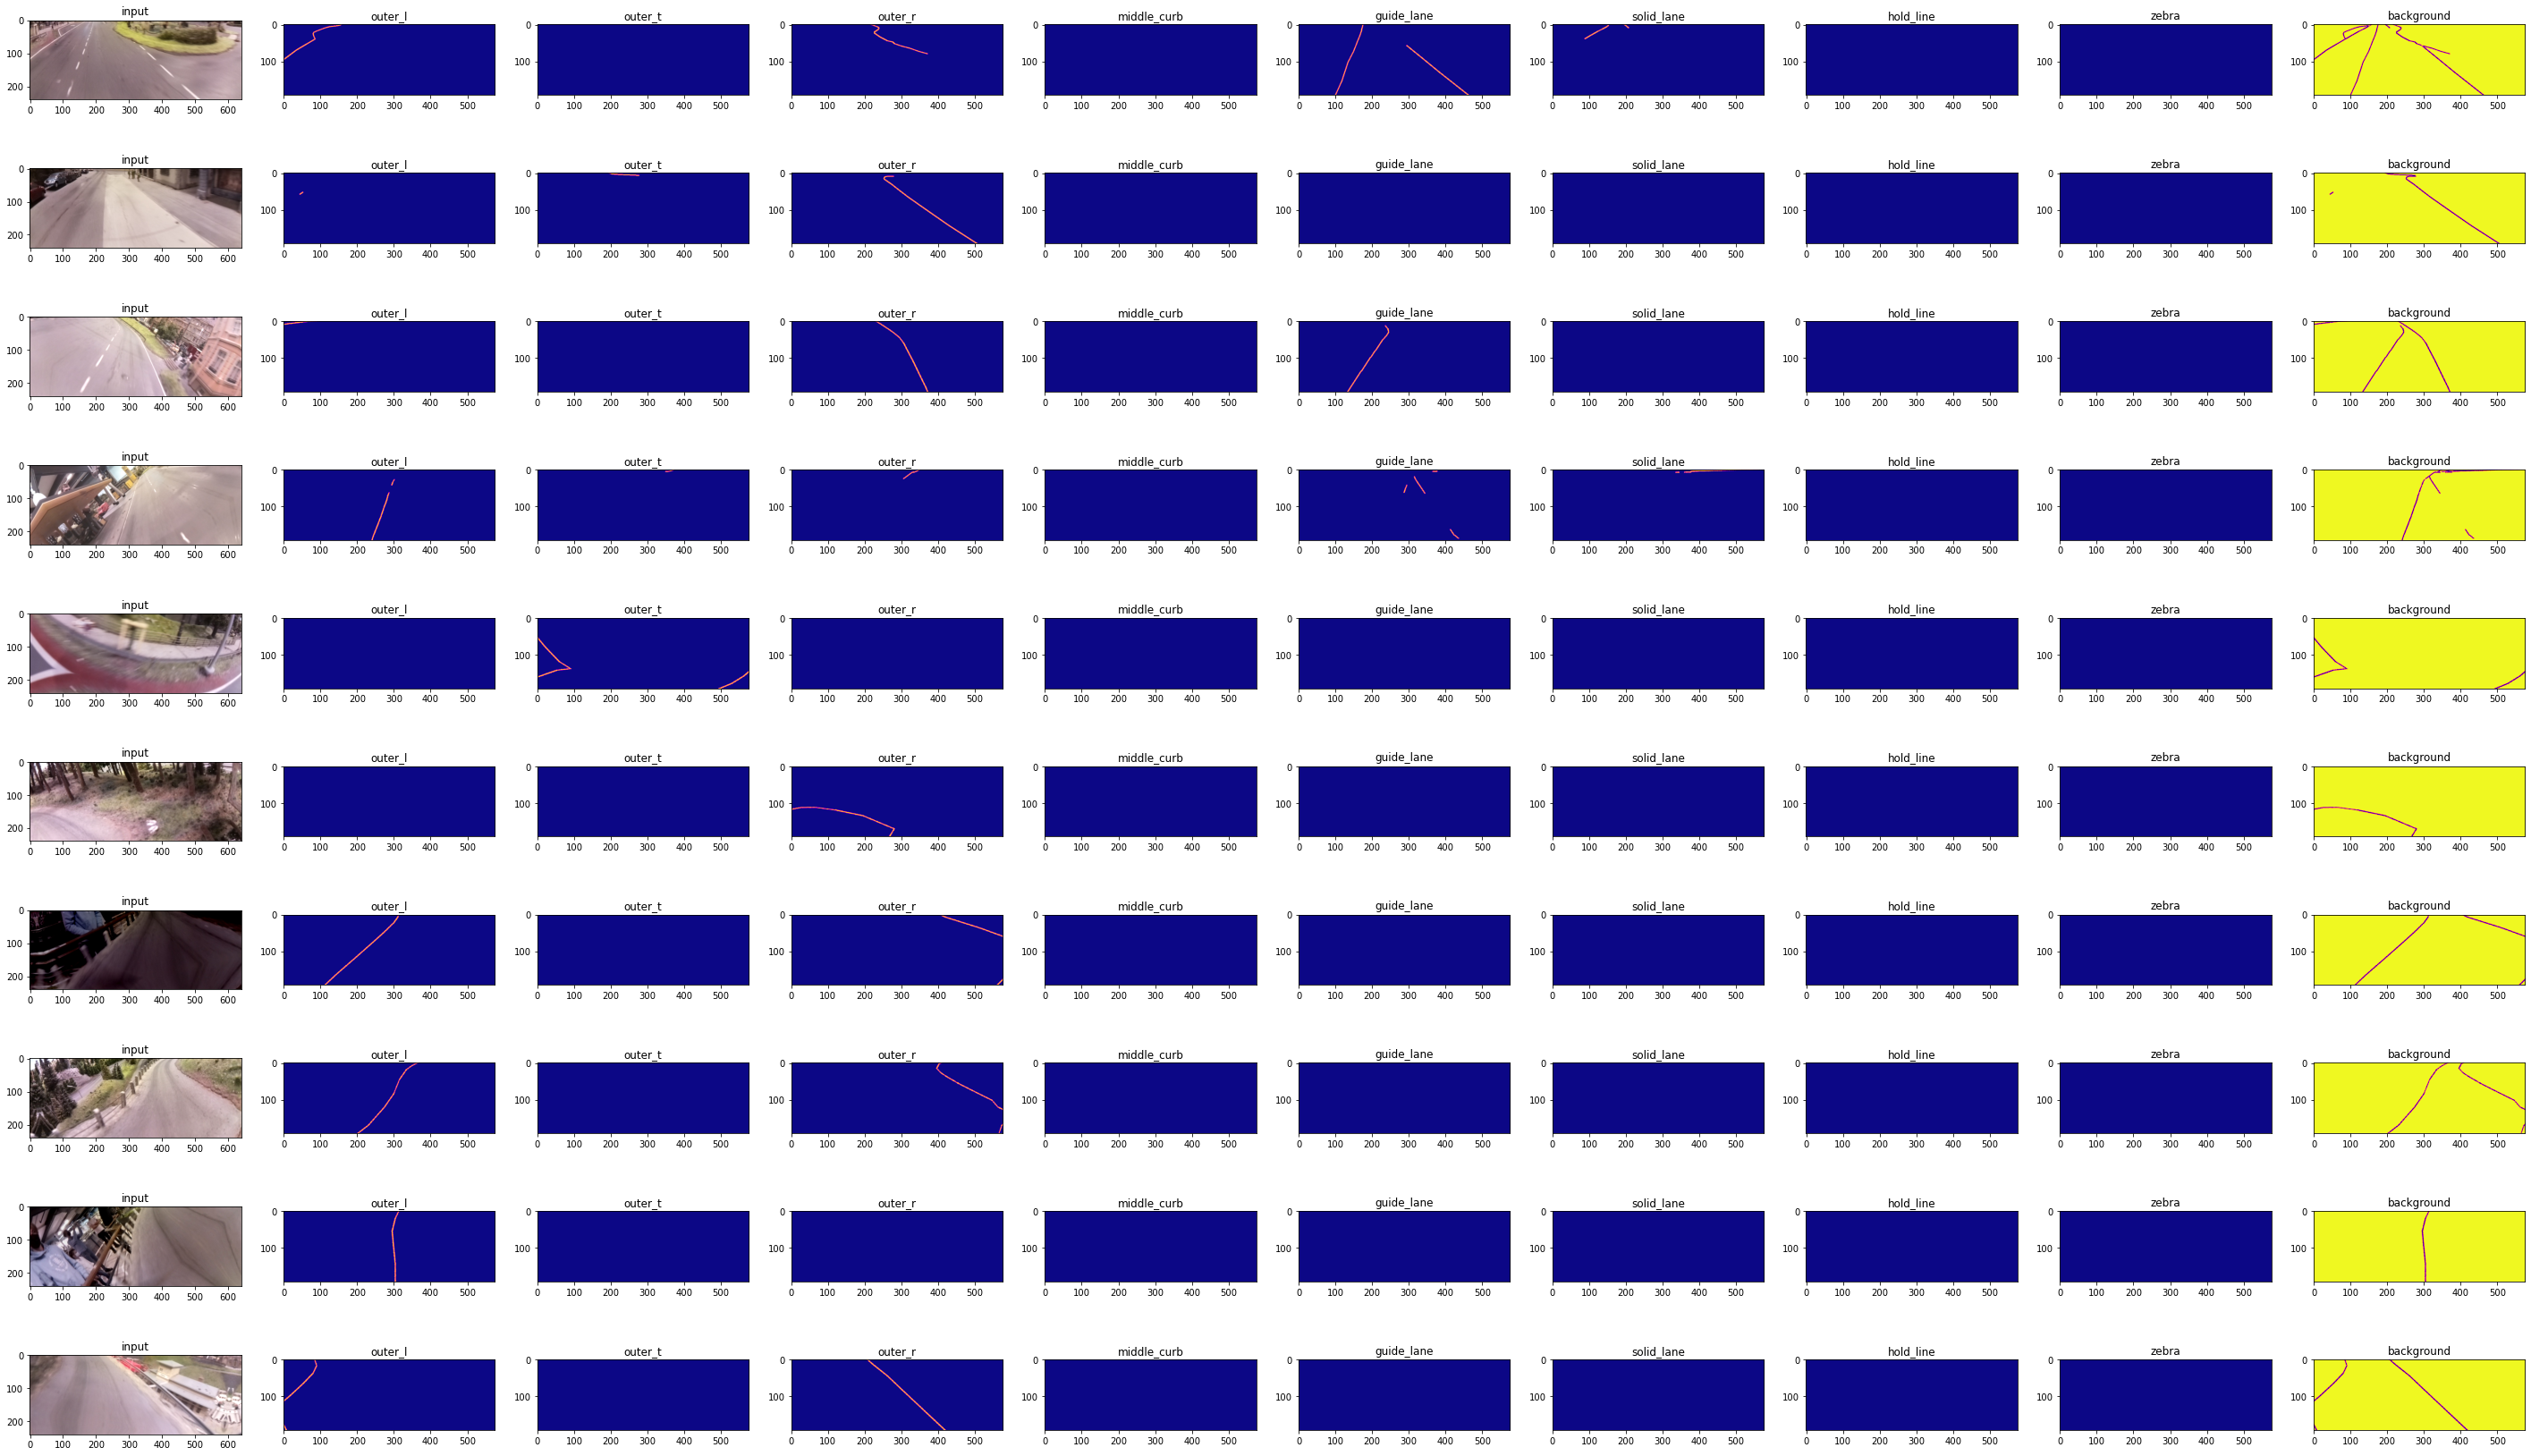

In [4]:
c = 10
f, axs = plt.subplots(c, 10, figsize=(50,c*3))
i = 0

batch_input_test = train_input_img_paths[:c]
batch_target_test = train_target_ann_paths[:c]
images, data = train_gen.data_generation(batch_input_test, batch_target_test)

print(len(images))
for y in range(c):
    axs[y,0].imshow(images[i])
    axs[y,0].title.set_text('input')
    axs[y,1].imshow(data[i][:,:,0], cmap='plasma')
    axs[y,1].title.set_text('outer_l')
    axs[y,2].imshow(data[i][:,:,1], cmap='plasma')
    axs[y,2].title.set_text('outer_t')
    axs[y,3].imshow(data[i][:,:,2], cmap='plasma')
    axs[y,3].title.set_text('outer_r')
    axs[y,4].imshow(data[i][:,:,3], cmap='plasma')
    axs[y,4].title.set_text('middle_curb')
    axs[y,5].imshow(data[i][:,:,4], cmap='plasma')
    axs[y,5].title.set_text('guide_lane')
    axs[y,6].imshow(data[i][:,:,5], cmap='plasma')
    axs[y,6].title.set_text('solid_lane')
    axs[y,7].imshow(data[i][:,:,6], cmap='plasma')
    axs[y,7].title.set_text('hold_line')
    axs[y,8].imshow(data[i][:,:,7], cmap='plasma')
    axs[y,8].title.set_text('zebra')
    axs[y,9].imshow(data[i][:,:,8], cmap='plasma')
    axs[y,9].title.set_text('background')
    i += 1

In [ ]:
def test_custom(name):
   # base_model = A.ResNet50V2(include_top=False, weights="imagenet", input_shape=(input_height,input_width,3)) 
   # base_model = A.InceptionV3(include_top=False, weights="imagenet", input_shape=(input_height,input_width,3)) 
    #base_model = A.VGG16(include_top=False, weights="imagenet", input_shape=(input_height,input_width,3))

    inputs = Input(shape=(input_height,input_width,3))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128]:
        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [128, 64, 32]:
        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(2)(x)

        # Project residual
        residual = UpSampling2D(2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding="same")(residual)
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
        
    output = Conv2D(number_classes, 1)(x)
    output = Activation('softmax')(output)
    
    model = Model(inputs=inputs, outputs=output, name=name)
    optimizer = Adam(lr=1e-4) # lr is learning rate
    loss = sm.losses.CategoricalCELoss() + sm.losses.DiceLoss()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[sm.metrics.iou_score]) # mean squared error because it is a regression problem
    #plot_model(model, to_file='%s.png' % (name))
    return model
keras.backend.clear_session()
model = test_custom('AUTOSYS_LANEDETECTION_CLS')
#model = custom_unet()
#model = segmentation_model()

print(model.summary())

In [6]:
# checkpoint
filepath="ld_autosys_checkpoint.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

tf.get_logger().setLevel('ERROR')

history = model.fit(train_gen,
            validation_data=val_gen,
            epochs=epochs,
            use_multiprocessing=True,
            workers=10,
            callbacks=callbacks_list)
model.save(model_path)

Epoch 1/40
13/13 [==============================] - 48s 3s/step - loss: 4.7857 - iou_score: 0.0340 - val_loss: 1.3057 - val_iou_score: 0.0334

Epoch 00001: val_loss improved from inf to 1.30568, saving model to ld_autosys_checkpoint.h5
Epoch 2/40
13/13 [==============================] - 47s 3s/step - loss: 0.3978 - iou_score: 0.1092 - val_loss: 0.3207 - val_iou_score: 0.0901

Epoch 00002: val_loss improved from 1.30568 to 0.32070, saving model to ld_autosys_checkpoint.h5
Epoch 3/40
13/13 [==============================] - 52s 2s/step - loss: 0.3110 - iou_score: 0.1119 - val_loss: 0.1942 - val_iou_score: 0.1074

Epoch 00003: val_loss improved from 0.32070 to 0.19422, saving model to ld_autosys_checkpoint.h5
Epoch 4/40
13/13 [==============================] - 54s 2s/step - loss: 0.2773 - iou_score: 0.1143 - val_loss: 0.2978 - val_iou_score: 0.1079

Epoch 00004: val_loss did not improve from 0.19422
Epoch 5/40
13/13 [==============================] - 59s 3s/step - loss: 0.2580 - iou_score

Process Keras_worker_ForkPoolWorker-547:
Process Keras_worker_ForkPoolWorker-546:
Process Keras_worker_ForkPoolWorker-545:
Process Keras_worker_ForkPoolWorker-548:
Process Keras_worker_ForkPoolWorker-532:
Process Keras_worker_ForkPoolWorker-550:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-544:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process Keras_worker_ForkPoolWorker-543:
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Pro

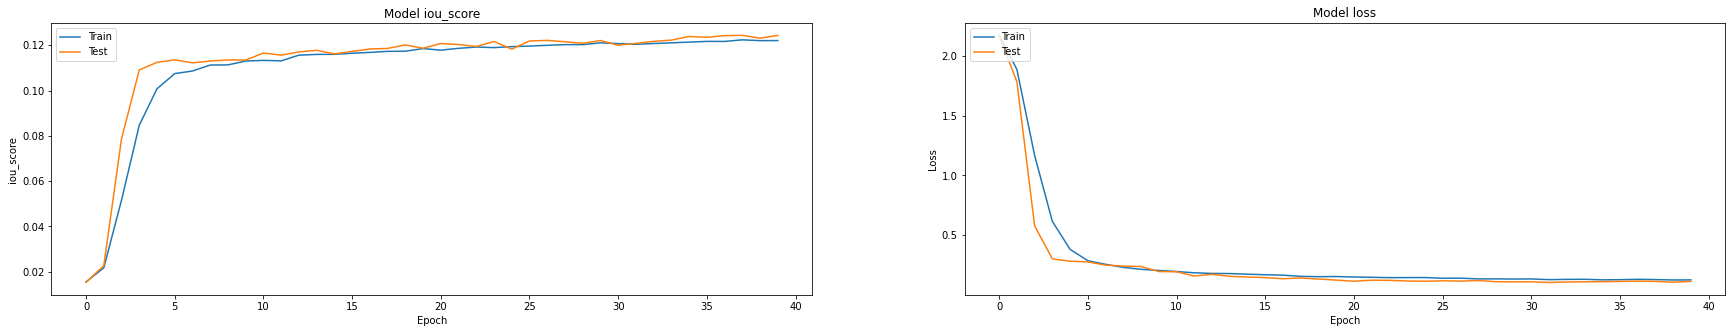

In [7]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('custom.png')
plt.show()



In [4]:
# load model only if not trained in this session\
model = load_model('./ld_autosys_checkpoint.h5', custom_objects={'iou_score':None})

In [5]:
# load some test images
cnt = 15

batch_input_test = train_input_img_paths[:cnt]
batch_target_test = train_target_ann_paths[:cnt]
images, data = train_gen.data_generation(batch_input_test, batch_target_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


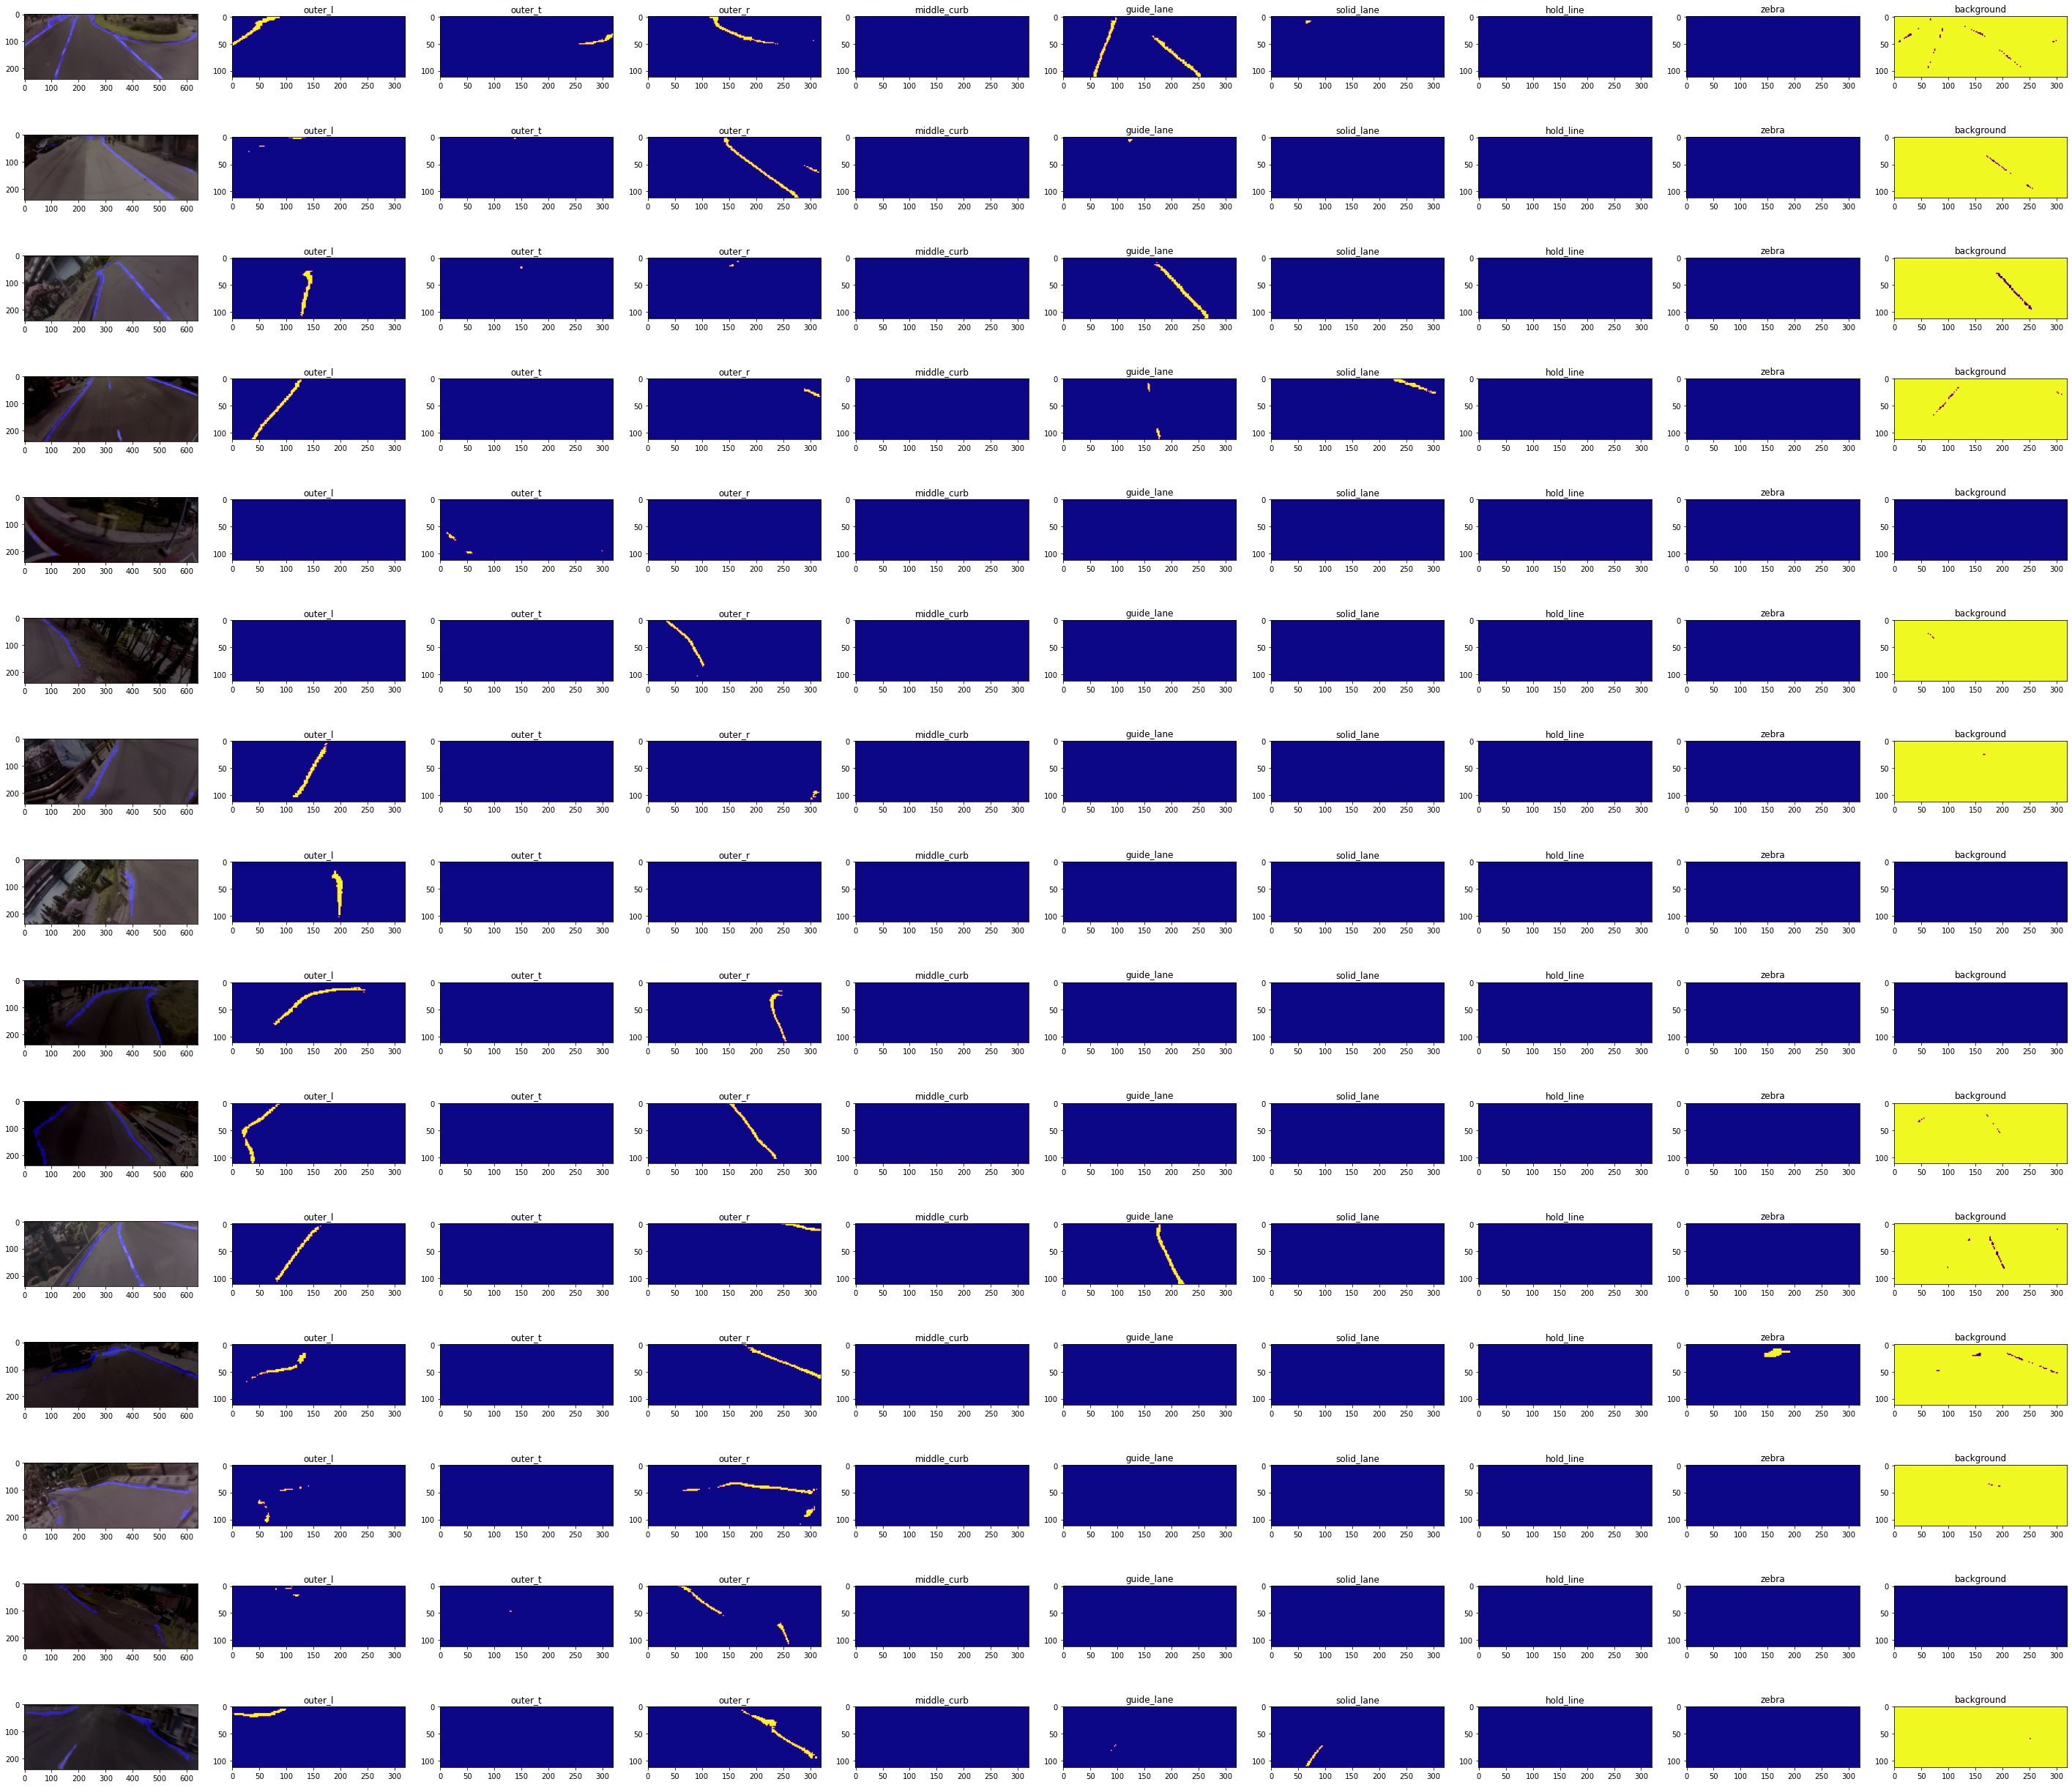

In [6]:
predictions = model.predict(np.array(images))[:cnt]

thres_value = 0.2

def postprocess_channel(img):
    #img = cv2.medianBlur(img, 3)
    _, img = cv2.threshold(img,thres_value,1.0,cv2.THRESH_BINARY)
    return img

f, axs = plt.subplots(len(predictions), 10, figsize=(50,len(predictions)*3))
for i, prediciton in enumerate(predictions):
    #test_img = cv2.resize(test_imgs[i], (x_values, y_values))
    test_img = images[i]
    test_img = test_img.astype(np.float32)
    predicted_lanes = np.sum([postprocess_channel(prediciton[:,:,i]) for i in range(8)], axis=0)
    predicted_lanes = cv2.merge([np.zeros_like(predicted_lanes), np.zeros_like(predicted_lanes), predicted_lanes])
    predicted_lanes = cv2.resize(predicted_lanes, (test_img.shape[1], test_img.shape[0]))
    overlay_image = cv2.addWeighted(test_img, 0.5, predicted_lanes, 0.5, 0)
    axs[i,0].imshow(overlay_image)
    #axs[i,0].imshow(test_imgs[i])

    axs[i,1].imshow(postprocess_channel(prediciton[:,:,0]), cmap='plasma')
    axs[i,1].title.set_text('outer_l')
    axs[i,2].imshow(postprocess_channel(prediciton[:,:,1]), cmap='plasma')
    axs[i,2].title.set_text('outer_t')
    axs[i,3].imshow(postprocess_channel(prediciton[:,:,2]), cmap='plasma')
    axs[i,3].title.set_text('outer_r')
    axs[i,4].imshow(postprocess_channel(prediciton[:,:,3]), cmap='plasma')
    axs[i,4].title.set_text('middle_curb')
    axs[i,5].imshow(postprocess_channel(prediciton[:,:,4]), cmap='plasma')
    axs[i,5].title.set_text('guide_lane')
    axs[i,6].imshow(postprocess_channel(prediciton[:,:,5]), cmap='plasma')
    axs[i,6].title.set_text('solid_lane')
    axs[i,7].imshow(postprocess_channel(prediciton[:,:,6]), cmap='plasma')
    axs[i,7].title.set_text('hold_line')
    axs[i,8].imshow(postprocess_channel(prediciton[:,:,7]), cmap='plasma')
    axs[i,8].title.set_text('zebra')
    axs[i,9].imshow(postprocess_channel(prediciton[:,:,8]), cmap='plasma')
    axs[i,9].title.set_text('background')